In [25]:
import math
import json
import os
import glob
import numpy as np
import argparse
import plotly.graph_objects as go
import functools
from plotly.subplots import make_subplots
from timeit import default_timer as timer
import pickle
from statistics import mean

In [26]:
class Scenario:
    def __init__(self,name,logs):
        self.name = name
        self.logs = logs
        
        
        #self.params = self.logs[0]['parameters']
    
    @staticmethod
    def resample(arr, step, tolerance,duration):
        '''
             resample per t'marre cdo x sekonda 
        '''
        res = {}

        for curr_time in range(0,duration,step):
            candidates = []
            diffs = []
            #candidates_idx = []
            #print(curr_time)
            ub = 0
            for i, t in enumerate(arr):
                diff = abs(float(t - curr_time))
                if diff <= tolerance:
                    candidates.append(i)
                    diffs.append(diff)
            if len(diffs) == 1:
                winner = candidates[0]
            elif len(diffs) > 1:
                val, idx = min((val, idx) for (idx, val) in enumerate(diffs)) #fut ate qe ka diferencen me t vogel me kohen e ownship
                winner = candidates[idx]
            else:
                winner = -1
                #print("Nuk gjetem gje per kohen "+str(curr_time))
            res[curr_time] = winner


        return res
    

    @functools.cached_property
    #@property
    def params(self):
        
        
        with open(self.logs[0],'r') as f:
            data = json.load(f)
        return data['parameters']
    
    @functools.cached_property
    def delay(self):
        d = []
        for log in self.logs:
            with open(log,'r') as f:
                data = json.load(f)
            ownship = data['state']
            delay = ownship['update_delay']
            if delay == 0.:
                traffic = data['traffic']['tf1']
                delay = traffic['time'][0] - ownship['time'][0]
            d.append(delay)
        
        return d
    @functools.cached_property
    def max_sev_per_run(self):
        dist_lowc_sev = self.dist_lowc_sev
        
        max_lowc_sev = []
        for run in dist_lowc_sev:
            sev = [d[2] for d in run.values()]
            max_lowc_sev.append(max(sev))
        return max_lowc_sev
    @functools.cached_property
    def lowc_duration(self):
        dist_lowc_sev = self.dist_lowc_sev
        
        max_lowc_sev = []
        for run in dist_lowc_sev:
            sev = [d[2] for d in run.values()]
            count = 0 
            for s in sev:
                if s > 0:
                    count+=1
            max_lowc_sev.append(count)
        return count
        
    @functools.cached_property
    #@property
    def dist_lowc_sev(self):
        h_thresh = self.get_thresh()
        dist_lowc_sev = []
        r = 0
        for log in self.logs:
            curr_dwc = {}
            with open(log,'r') as f:
                data = json.load(f)
            
            traffic = data['traffic']['tf1']
            ownship = data['state']
            
            duration = 300 #sekonda
            step = 1 # cdo 1 sekonda
            tolerance = 0.5 # merr me te aferten ne dritare +- 0.5 sekonda
        
            resampled_ownship = Scenario.resample(ownship['time'],step,tolerance,duration)
            resampled_traffic = Scenario.resample(traffic['time'],step,tolerance,duration)
            
            
            for i in range(0, duration, step):
                if resampled_ownship[i] != -1 and resampled_traffic[i] != -1:
                    
                    posNED = ownship['positionNED'][resampled_ownship[i]]
                    tposNED = traffic['positionNED'][resampled_traffic[i]]
                    
                    dist = np.sqrt((posNED[0] - tposNED[0])**2 + (posNED[1] - tposNED[1])**2) 
            
                    horiz_violation = (dist < h_thresh)
                    
                    #h.append(dist)

                    if horiz_violation:
                        lowc = 1
                    else:
                        lowc = 0
                        
                    sev = (h_thresh - dist) / h_thresh
                    if sev < 0:
                        sev = 0
                    curr_dwc[i] = (dist, lowc,sev)
            dist_lowc_sev.append(curr_dwc)
            r +=1
            
            
        
        return dist_lowc_sev
    
    @functools.cached_property
    #@property
    def severity(self):
        severity = []
        dist_lowc = self.dist_lowc
        h_thresh = self.get_thresh()
        for run in dist_lowc:
            print(run)
            run_sev = {}
            for time, d_lwc in run.items():
                dist = d_lwc[0]
                sev = (h_thresh - dist) / h_thresh
                if sev < 0:
                    sev = 0
                run_sev[time] = sev
            
            severity.append(run_sev)
        return severity
        
    @functools.cached_property
    #@property
    def mean_severity(self):
        dist_lowc_sev = self.dist_lowc_sev
        
        #print(dist_lowc_sev)
        mean_severity = {}
        for i in range(0,300, 1):
            values = []
            for run in dist_lowc_sev:
                if i in run.keys():
                    values.append(run[i][2])
                
            if len(values) > 0:
                mean_severity[i] = (sum(values) / len(values), len(values))
        
        
        return mean_severity
    
    @functools.cached_property
    def mean_dist(self):
        dist_lowc_sev = self.dist_lowc_sev
        mean_dist = {}
        
        for i in range(0,300, 1):
            values = []
            for run in dist_lowc_sev:
                if i in run.keys():
                    values.append(run[i][0])
            if len(values) > 0:
                
                mean_dist[i] = (sum(values) / len(values), len(values))   
            #mean_dist[i] = (sum(values) / len(values), len(values))
            
        return mean_dist
    
        
        
    
    @functools.cached_property
    def max_mean_severity(self):
        mean_severity = self.mean_severity
        sev = [d[0] for d in mean_severity.values()]
        return max(sev)
    
    
    def get_thresh(self):
        return self.params['DET_1_WCV_DTHR']* 0.3048
    @functools.cached_property
    def t_lookahead(self):
        return self.params['LOOKAHEAD_TIME']
    @functools.cached_property
    def t_alert(self):
        return self.params['AL_1_ALERT_T']
    @functools.cached_property
    def turn_rate(self):
        return self.params['TURN_RATE']
    
    def get_param(self, key):
        if key in self.params.keys():
            return self.params[key]
        else:
            return 'Nuk ke gje ktu'
    
    

In [27]:
def calcLossOfHorizontalSafetyDistance(ownship, traffic, h_THRESHOLD):
        h = []
        lowc = []
        
        resample_ownship = resample(ownship['time'],step, tolerance, duration)
        resample_traffic = resample(traffic['time'], step, tolerance, duration)
        
        for i, tposNED in enumerate(traffic['positionNED']):
            posNED = ownship["positionNED"][i]
            o_alt = posNED[2]
            t_alt = tposNED[2]
            
            dist = np.sqrt((posNED[0] - tposNED[0])**2 + (posNED[1] - tposNED[1])**2) 
            
            horiz_violation = (dist < h_THRESHOLD)
            
            h.append(dist)

            if horiz_violation:
                lowc.append(1)
            else:
                lowc.append(0)
        
        lowcNP = np.array(lowc)
        hNP = np.array(h)
        
        return (lowcNP, hNP)
    
def findRangeOfOnes(zeroOneNPArray):
    idx = np.where(zeroOneNPArray==1)[0]
    
    if len(idx) > 0:
        return [idx[0], idx[-1]]
    else:
        return [-1, -1]

def regainSafetyDistance(zeroOneNPArray):
    return np.any(np.diff(zeroOneNPArray) == -1)
    #zeroOneNPArray_idx = findRangeOfOnes(zeroOneNPArray)
    #return -1 < zeroOneNPArray_idx[1] and zeroOneNPArray_idx[0] < len(zeroOneNPArray)-1

def calculate_time(zeroOneNPArray):
    return sum(zeroOneNPArray) * samplingRate

def calcSeverity(h_dist, h_THRESHOLD):
    h_severity = (h_THRESHOLD - h_dist) / h_THRESHOLD
    h_severity[h_severity < 0] = 0
    return h_severity


In [28]:
with open("final_results.dat","rb") as f:
    scenarios = pickle.load(f)

ENCOUNTER GEOMETRY for Max and Min WC Threshold

In [29]:
St5tr90h0_mean_max = []
St5tr90h90_mean_max = []
St9tr30h0_mean_max = []
St9tr30h90_mean_max = []
others = []

for scenario in scenarios:
    
    values = []
    for run in scenario.dist_lowc_sev:
        maksimum = max([v[2] for v in run.values()])
        values.append(maksimum)
    if "St5tr90h0" in scenario.name: 
        St5tr90h0_mean_max.append(np.mean(values))
    elif "St5tr90h90" in scenario.name: 
        St5tr90h90_mean_max.append(np.mean(values))
    elif "St9tr30h0" in scenario.name:
        St9tr30h0_mean_max.append(np.mean(values))
    elif "St9tr30h90" in scenario.name:
        St9tr30h90_mean_max.append(np.mean(values))
    else:
        continue


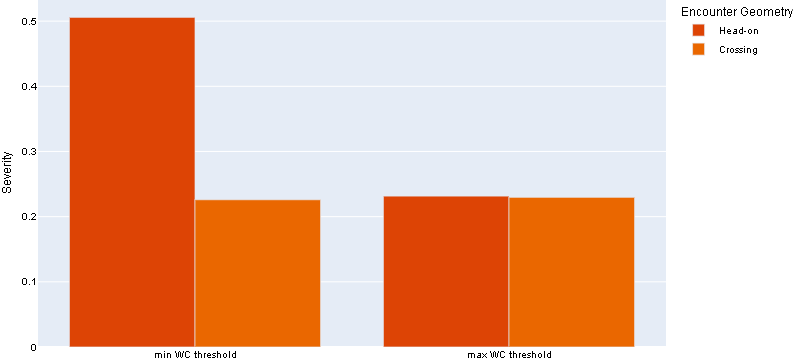

In [30]:
import plotly.graph_objects as go
t2=['min WC threshold', 'max WC threshold']
s= [np.mean(St5tr90h0_mean_max),np.mean(St5tr90h90_mean_max)]
p = [np.mean(St9tr30h0_mean_max),np.mean(St9tr30h90_mean_max)]

fig = go.Figure(data=[
    go.Bar(name='Head-on', x=t2, y=s, marker={'color': '#dd4405'}),
    go.Bar(name='Crossing', x=t2, y=p, marker={'color': '#ea6700'})
])
# Change the bar mode
fig.update_layout(barmode='group',margin=go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=0  #top margin
    ),
    #title="Maximum Severity for Encounter Geometry", title_x=0.5, 
    #xaxis_title="Time (s)",
    yaxis_title="Severity",
    legend_title="Encounter Geometry",
    font=dict(
        family="Helvetica",
        size=10,
        color="Black"
    )
)

fig.write_image("images/geometry.pdf")
fig.show()

CLOSURE RATE (Head-on, min(t1) and min (t2)

In [20]:
St5tr90h0v20vi10_mean = []
St5tr90h0v20vi15_mean = []
St5tr90h0v10vi10_mean = []
St5tr90h0v10vi15_mean = []

for scenario in scenarios:
    
    values = []
    for run in scenario.dist_lowc_sev:
        maksimum = max([v[2] for v in run.values()])
        values.append(maksimum)
    if "St5tr90h0v20vi10" in scenario.name: 
        St5tr90h0v20vi10_mean.append(np.mean(values))
    elif "St5tr90h0v20vi15" in scenario.name: 
        St5tr90h0v20vi15_mean.append(np.mean(values))
    elif "St5tr90h0v10vi10" in scenario.name:
        St5tr90h0v10vi10_mean.append(np.mean(values))
    elif "St5tr90h0v10vi15" in scenario.name:
        St5tr90h0v10vi15_mean.append(np.mean(values))
    else:
        continue

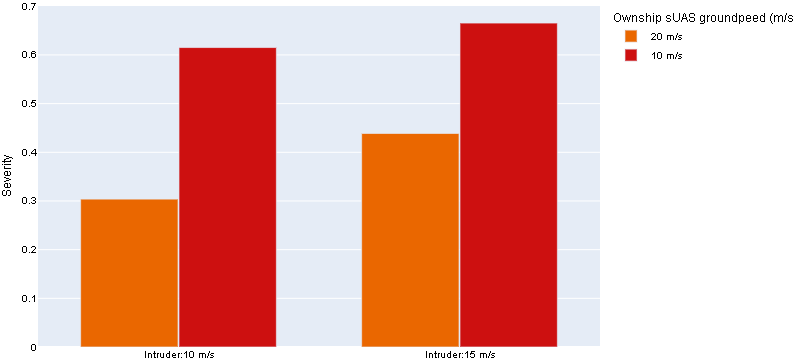

In [23]:
import plotly.graph_objects as go
t2=['Intruder:10 m/s', 'Intruder:15 m/s']
q= [np.mean(St5tr90h0v20vi10_mean),np.mean(St5tr90h0v20vi15_mean)]
r =[np.mean(St5tr90h0v10vi10_mean),np.mean(St5tr90h0v10vi15_mean)]

fig = go.Figure(data=[
    go.Bar(name='20 m/s', x=t2, y=q,marker={'color':'#ea6700'}),
    go.Bar(name='10 m/s', x=t2, y=r,marker={'color':'#cd1010'})
])
# Change the bar mode
fig.update_layout(barmode='group',bargap=0.3, bargroupgap=0.01,margin=go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=0  #top margin
    ),
    #title="Maximum Severity wrt Closure Rate", title_x=0.5, 
    #xaxis_title="Time (s)",
    yaxis_title="Severity",
    legend_title="Ownship sUAS groundpeed (m/s)",
    font=dict(
        family="Helvetica",
        size=10,
        color="Black"
    )
)

fig.write_image("images/cr.pdf")
fig.show()

Determine which factor affects more Severity: Communication Delay , Wind

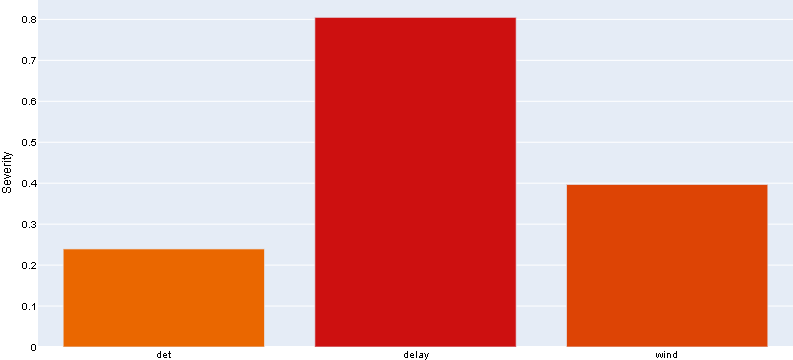

In [24]:
a=['det','delay','wind']
b=[0.2395, 0.805, 0.3969]
c = ['#ea6700','#cd1010','#dd4405']
fig = go.Figure(data=[
    go.Bar(name='90 deg/s - 20 m/s', x=a, y=b, marker_color=c)])

fig.update_layout( margin=go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=0  #top margin
    ),
    #xaxis_title="Time (s)",
    yaxis_title="Severity",
    #legend_title="sUAS turning rate and air speed",
    font=dict(
        family="Helvetica",
        size=10,
        color="Black"))
fig.write_image("images/factors.pdf")
fig.show()